In [336]:
from PIL import Image
import cv2 
import numpy as np
import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [ ]:
img_list = glob.glob("paris_train_original.nosync/*.JPG")

In [31]:
images = []
for i in img_list:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    images.append(pil_img)
    
images = np.array(images)
images.shape

In [43]:
upper = [np.random.randint(0,537), np.random.randint(0,936)] 
lower = [np.random.randint(upper[0],537), np.random.randint(upper[1],936)] 



In [47]:
images[0][upper[0]:lower[0],upper[1]:lower[1]] = 255

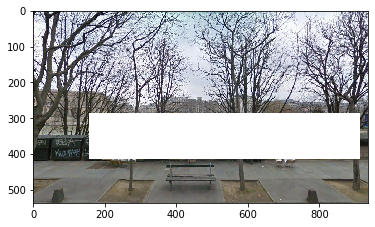

In [100]:
plt.imshow(images[0])

In [415]:
# TO FIX
# overlaps
# not exactly 25%
# Squares can differ in sizes 
def cover_percentage(img):
    img = img.copy()
    for i in range(8):
        img_perc_covered = img.flatten()
        img_perc_covered = np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0]
        if(img_perc_covered < 0.25):
            cover = [150,150]
            corner = [np.random.randint(0,537-cover[0]), np.random.randint(0,936-cover[1])] 
            img[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255
            
        else:
            img_perc_covered = img.flatten()
            #print((np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0])*100)
            break
    return img
            
            

In [416]:
cover_percentage(images[89])

array([[[147, 141, 143],
        [173, 167, 169],
        [189, 180, 183],
        ...,
        [217, 213, 210],
        [216, 212, 209],
        [216, 212, 209]],

       [[165, 159, 161],
        [181, 175, 177],
        [186, 177, 180],
        ...,
        [218, 214, 211],
        [219, 215, 212],
        [219, 215, 212]],

       [[181, 175, 177],
        [186, 180, 182],
        [181, 172, 175],
        ...,
        [219, 215, 212],
        [221, 217, 214],
        [222, 218, 215]],

       ...,

       [[139, 145, 143],
        [140, 146, 144],
        [142, 146, 145],
        ...,
        [ 29,  46,  72],
        [ 29,  46,  72],
        [ 29,  46,  72]],

       [[144, 148, 147],
        [146, 150, 149],
        [148, 152, 151],
        ...,
        [ 45,  65,  89],
        [ 43,  63,  88],
        [ 43,  63,  88]],

       [[148, 152, 151],
        [146, 150, 149],
        [152, 156, 155],
        ...,
        [ 61,  81, 105],
        [ 57,  77, 101],
        [ 51,  71,  95]]

# Data Formatting for pytorch + Train Test Split

In [520]:
class ToFillDataset_train(Dataset):
    def __init__(self, images, corrupted_images=None):
        self.images = images
        self.corrupted_images = corrupted_images
        
    def corrupt_image(self, img):
        img = img.copy()
        for i in range(8):
            img_perc_covered = img.flatten()
            img_perc_covered = np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0]
            if(img_perc_covered < 0.25):
                cover = [150,150]
                corner = [np.random.randint(0,537-cover[0]), np.random.randint(0,936-cover[1])] 
                img[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255
            else:
                img_perc_covered = img.flatten()
                break
        return img
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = self.images[item]
        
        if type(self.corrupted_images) == int :
            corrupt_images = self.corrupt_image(self.images[item])
        else:
            corrupt_images = self.corrupted_images[item]
            
        
        return {
          'image': image,
          'corrupt_image': corrupt_images ,
        }

In [521]:
def create_data_loader(images ,corrupt_images = 0 ):
    ds = ToFillDataset_train(images, corrupt_images)
    return DataLoader(ds, batch_size = 16) 

In [522]:
train = create_data_loader(images)

In [523]:
training_data_loaded = next(iter(train))

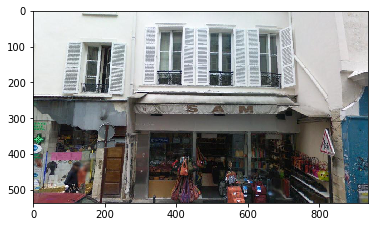

In [524]:
plt.imshow(training_data_loaded["image"][10])

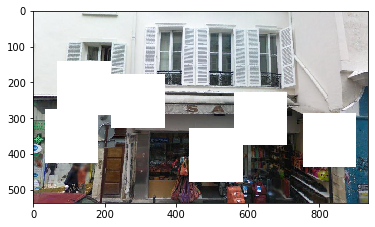

In [525]:
plt.imshow(training_data_loaded["corrupt_image"][10])

In [526]:
test_images_loc = glob.glob("paris_eval.nosync/paris_eval_gt/*.png")

In [527]:
test_images_corrupt_loc = glob.glob("paris_eval.nosync/paris_eval_corrupted/*.png")

In [528]:
test_images = []
for i in test_images_loc:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    test_images.append(pil_img)
    
test_images = np.array(test_images)
test_images.shape

(100, 227, 227, 3)

In [529]:
test_images_corrupt = []
for i in test_images_corrupt_loc:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    test_images_corrupt.append(pil_img)
    
test_images_corrupt = np.array(test_images_corrupt)
test_images_corrupt.shape

(100, 227, 227, 3)

In [530]:
test = create_data_loader(test_images,test_images_corrupt)

In [531]:
testing_data_loaded = next(iter(test))

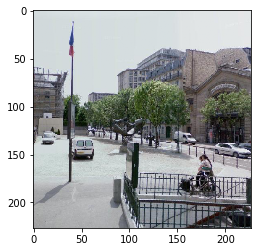

In [533]:
plt.imshow(testing_data_loaded["image"][10])

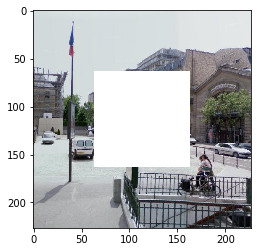

In [534]:
plt.imshow(testing_data_loaded["corrupt_image"][10])